# **Regression Model**

### **De hoeveelheid bestelde aantallen per product per bestelling**

##### Relevantie:
Het regressiemodel met 'Quantity' als afhankelijke variabele biedt waardevolle inzichten voor het optimaliseren van voorraadbeheer en logistieke planning. Door nauwkeurige voorspellingen te maken over de hoeveelheid bestelde producten per bestelling, kunnen bedrijven efficiënter inkopen en voorraadniveaus beter afstemmen op de verwachte vraag. Dit helpt om kosten te besparen door overvoorraad en stock-outs te minimaliseren, de klanttevredenheid te verhogen door tijdige leveringen te garanderen, en uiteindelijk de operationele efficiëntie te verbeteren. Het model ondersteunt strategische besluitvorming en draagt bij aan een gestroomlijnde supply chain.

##### Inschatting van Bijpassende Onafhankelijke Variabelen:
**UnitPrice** UnitPrice is de eenheidsprijs van het product. Dit heeft een direct effect op de bestelhoeveelheid, aangezien hogere prijzen vaak leiden tot lagere hoeveelheden bestellingen.

**UnitPriceDiscount** UnitPriceDiscount is de korting op de eenheidsprijs. Dit kan van invloed zijn op de bestelhoeveelheid, aangezien klanten geneigd zijn meer te kopen wanneer er kortingen worden aangeboden.

**LineTotal** LineTotal is het totaalbedrag van een bepaald product van een order. Dit kan helpen bij het begrijpen van de omvang van de bestellingen in relatie tot de hoeveelheid.

**CustomerID_AW** CustomerID_AW is de unieke klant-ID van AdventureWorks. Verschillende klanten kunnen verschillende bestelpatronen hebben.

**ProductID_AW** ProductID_AW is de unieke product-ID van AdventureWorks. Verschillende producten kunnen verschillende verkooptrends hebben.

**Freight** Freight is de verzendkosten. Dit kan invloed hebben op de hoeveelheid die wordt besteld, aangezien hogere verzendkosten mogelijk een remmende factor zijn.

**SubTotal** SubTotal is het subtotaal van de bestelling zonder belasting. Dit kan een indicator zijn voor de totale orderomvang.

**TaxAmt** TaxAmt is het belastingbedrag. Dit kan indirect invloed hebben op de bestelgrootte door de totale kosten te verhogen.

**ShipMethodID** ShipMethodID is de ID van de verzendmethode. Verschillende verzendmethoden kunnen verschillende kosten en levertijden hebben, wat de bestelgrootte kan beïnvloeden.

**Year, Month, Day** Year, Month, Day zijn de jaar-, maand- en dagwaarden van de orderdatum, gecodeerd als dummyvariabelen. Deze variabelen kunnen seizoensgebonden trends en variaties in bestelhoeveelheden weerspiegelen.

In [28]:
import pandas as pd
import warnings
import numpy as np
import sqlite3
from loguru import logger
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

In [29]:
# SQLite Connecties
logger.info('Establishing connection with SQLite databases...')
conn = sqlite3.connect('../../data/processed/United_Outdoors.sqlite3')
logger.success('Connections established!')

# Connect to the SQLite database
cursor = conn.cursor()

2024-05-28 22:16:01.429 | INFO     | __main__:<module>:2 - Establishing connection with SQLite databases...
2024-05-28 22:16:01.452 | SUCCESS  | __main__:<module>:4 - Connections established!


In [30]:
order = pd.read_sql_query('SELECT SalesOrderID, OrderQty, UnitPrice, UnitPriceDiscount, LineTotal, CustomerID_AW, ProductID_AW, Freight, SubTotal, TaxAmt, ShipMethodID, OrderDate FROM Order_Details', conn)

order = order.rename(columns={'OrderQty': 'Quantity'})

order['OrderDate'] = pd.to_datetime(order['OrderDate'])
order['Year'] = order['OrderDate'].dt.year
order['Month'] = order['OrderDate'].dt.month
order['Day'] = order['OrderDate'].dt.day

order = order.drop(columns=['OrderDate'], axis=1)

order = pd.get_dummies(order, columns=['Year', 'Month', 'Day'])

order.fillna(order.mean(), inplace=True)
order.fillna(order.mode().iloc[0], inplace=True)


In [31]:
X = order.drop(columns=['Quantity'])
y = order['Quantity']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42
)

In [32]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)
reg_model

LinearRegression()

In [33]:
y_pred = reg_model.predict(X_test)
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns={0: 'Predicted Quantity'})
y_test_prediction_merge = pd.concat([y_test.reset_index()['Quantity'], prediction_df], axis=1)
y_test_prediction_merge['Predicted Quantity'] = np.where(y_test_prediction_merge['Predicted Quantity'] < 0, 1, y_test_prediction_merge['Predicted Quantity'])

y_test_prediction_merge

,Quantity,Predicted Quantity
0,4.0,5.548064
1,1.0,1.512870
2,1.0,0.374873
3,6.0,7.788080
4,1.0,1.450559
...,...,...
18614,1.0,3.055351
18615,1.0,1.285469
18616,1.0,0.837772
18617,1.0,1.466127


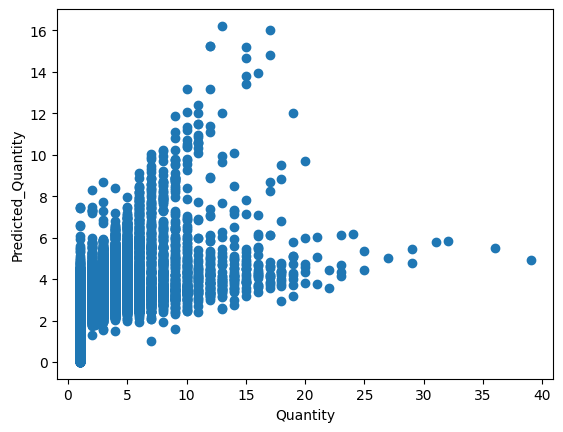

In [34]:
plt.scatter(y_test_prediction_merge['Quantity'], y_test_prediction_merge['Predicted Quantity'])
plt.xlabel('Quantity')
plt.ylabel('Predicted_Quantity')
plt.show()

In [35]:
mean_squared_error(y_test_prediction_merge['Quantity'], y_test_prediction_merge['Predicted Quantity'])

3.536464746437627

In [36]:
mean_absolute_error(y_test_prediction_merge['Quantity'], y_test_prediction_merge['Predicted Quantity'])

0.9703532950509784